<a href="https://colab.research.google.com/github/caio-git/stance_detection/blob/main/Stance_Detection_definitive_edition_FNC_dataset_v3_(random_oversample).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libs and data

In [ ]:
import pandas as pd
import re, nltk, string, scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, make_scorer, precision_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#nltk.download('rslp')
!pip install unidecode
import unidecode

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 241 kB 14.0 MB/s 


In [ ]:
!wget -O /content/stance_detection_3.zip https://github.com/caio-git/datasets/blob/main/train_test_FNC.zip?raw=true
!unzip /content/stance_detection_3.zip

--2021-09-03 18:07:09--  https://github.com/caio-git/datasets/blob/main/train_test_FNC.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/caio-git/datasets/raw/main/train_test_FNC.zip [following]
--2021-09-03 18:07:09--  https://github.com/caio-git/datasets/raw/main/train_test_FNC.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caio-git/datasets/main/train_test_FNC.zip [following]
--2021-09-03 18:07:09--  https://raw.githubusercontent.com/caio-git/datasets/main/train_test_FNC.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
df_bodies = pd.read_csv('/content/train_bodies_origin.csv', index_col=False)
df_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [ ]:
df_stances = pd.read_csv('/content/train_stances_origin.csv', index_col=False)
df_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [ ]:
df_merged = df_bodies.merge(df_stances, left_on='Body ID', right_on='Body ID')
df_merged.rename(columns={'articleBody':'news', 'Headline':'headline', 'Stance':'tag'}, inplace=True)
df = df_merged.drop(columns='Body ID')
df.head()

,news,headline,tag
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [ ]:
df_test_bodies = pd.read_csv('https://github.com/FakeNewsChallenge/fnc-1/blob/master/competition_test_bodies.csv?raw=true', index_col=False)
df_test_bodies.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [ ]:
df_test_stances = pd.read_csv('https://github.com/FakeNewsChallenge/fnc-1/blob/master/competition_test_stances.csv?raw=true', index_col=False)
df_test_stances.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [ ]:
df_test_merged = df_test_bodies.merge(df_test_stances, left_on='Body ID', right_on='Body ID')
df_test_merged.rename(columns={'articleBody':'news', 'Headline':'headline', 'Stance':'tag'}, inplace=True)
df_test = df_test_merged.drop(columns='Body ID')
df_test.head()

,news,headline,tag
0,Al-Sisi has denied Israeli reports stating tha...,Apple installing safes in-store to protect gol...,unrelated
1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree
2,Al-Sisi has denied Israeli reports stating tha...,Apple to keep gold Watch Editions in special i...,unrelated
3,Al-Sisi has denied Israeli reports stating tha...,Apple Stores to Keep Gold “Edition” Apple Watc...,unrelated
4,Al-Sisi has denied Israeli reports stating tha...,South Korean woman's hair 'eaten' by robot vac...,unrelated


## Text preprocessing

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
#stopwords = [unidecode.unidecode(word) for word in stopwords]
from nltk.stem import PorterStemmer 
stemmer = PorterStemmer()

In [ ]:
def text_preprocess(text):
  text = re.sub(r'\s+', ' ', text) 
  text = unidecode.unidecode(text)
  text = re.sub('[^a-zA-Z\s]', '', text)
  text = text.lower()

  tokens = []
  for token in nltk.word_tokenize(text):
    tokens.append(token)
      
  tokens = [stemmer.stem(token) for token in tokens if token not in stopwords and token not in string.punctuation]
  preprocessed_text = ' '.join([str(word) for word in tokens if not word.isdigit()])

  return preprocessed_text

In [ ]:
df['news_preprocessed'] = df['news'].apply(text_preprocess)
df['headline_preprocessed'] = df['headline'].apply(text_preprocess)
df.drop(columns=['news', 'headline'], inplace=True)

In [ ]:
df_test['news_preprocessed'] = df_test['news'].apply(text_preprocess)
df_test['headline_preprocessed'] = df_test['headline'].apply(text_preprocess)
df_test.drop(columns=['news', 'headline'], inplace=True)

In [ ]:
df.head()

,tag,news_preprocessed,headline_preprocessed
0,unrelated,small meteorit crash wood area nicaragua capit...,soldier shot parliament lock gunfir erupt war ...
1,unrelated,small meteorit crash wood area nicaragua capit...,tourist dub spider man spider burrow skin day
2,unrelated,small meteorit crash wood area nicaragua capit...,luke somer kill fail rescu attempt yemen
3,unrelated,small meteorit crash wood area nicaragua capit...,break soldier shot war memori ottawa
4,unrelated,small meteorit crash wood area nicaragua capit...,giant ft catfish weigh stone caught itali thou...


In [ ]:
df_test.head()

,tag,news_preprocessed,headline_preprocessed
0,unrelated,alsisi deni isra report state offer extend gaz...,appl instal safe instor protect gold watch edit
1,agree,alsisi deni isra report state offer extend gaz...,elsisi deni claim hell give sinai land palesti...
2,unrelated,alsisi deni isra report state offer extend gaz...,appl keep gold watch edit special instor safe
3,unrelated,alsisi deni isra report state offer extend gaz...,appl store keep gold edit appl watch custom safe
4,unrelated,alsisi deni isra report state offer extend gaz...,south korean woman hair eaten robot vacuum cle...


## Cosine similarity feature extraction

In [ ]:
vectorizer_for_cos_sim = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words=stopwords)

In [ ]:
def cos_sim_extractor(news_headline_df):
  news_and_headline = []
  news_and_headline.append(news_headline_df['news_preprocessed'])
  news_and_headline.append(news_headline_df['headline_preprocessed'])
  tfidf = vectorizer_for_cos_sim.fit_transform(news_and_headline)
  cosine_similarity_news_headline = (tfidf * tfidf.T).A
  return cosine_similarity_news_headline[0][1]

In [ ]:
df['cosine_similarity_value'] = df.apply(cos_sim_extractor, axis=1)

In [ ]:
df_test['cosine_similarity_value'] = df_test.apply(cos_sim_extractor, axis=1)

## Word superposition feature extraction

In [ ]:
def superposition_counter(df_x_train):
  news = set(df_x_train['news_preprocessed'].split(' '))
  headline = set(df_x_train['headline_preprocessed'].split(' '))
  superposition = len((news).intersection(headline)) / float(len(news.union(headline)))  
  return superposition

In [ ]:
df['superposition'] = df.apply(superposition_counter, axis=1)

In [ ]:
df_test['superposition'] = df_test.apply(superposition_counter, axis=1)

## Train test split

In [ ]:
df.tag.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: tag, dtype: int64

In [ ]:
count_unrelated, count_discuss, count_agree, count_disagree = df.tag.value_counts()

In [ ]:
df_unrelated = df[df['tag'] == 'unrelated']
df_discuss = df[df['tag'] == 'discuss']
df_agree = df[df['tag'] == 'agree']
df_disagree = df[df['tag'] == 'disagree']

In [ ]:
df_discuss_over = df_discuss.sample(count_unrelated, replace=True)
df_agree_over = df_agree.sample(count_unrelated, replace=True)
df_disagree_over = df_disagree.sample(count_unrelated, replace=True)

df_over = pd.concat([df_unrelated, df_discuss_over, df_agree_over, df_disagree_over], axis=0)

print('Random oversampling:')
print(df_over.tag.value_counts())

Random oversampling:
discuss      36545
disagree     36545
agree        36545
unrelated    36545
Name: tag, dtype: int64


In [ ]:
df_over.sample(10)

,tag,news_preprocessed,headline_preprocessed,cosine_similarity_value,superposition
34221,discuss,man behind ottawa shoot canadian convert islam...,updat soldier gunman die ottawa rampag identifi,0.052635,0.027586
19207,discuss,seth rogen set star steve wozniak opposit chri...,seth rogen star steve wozniak soni steve job b...,0.265452,0.067227
9252,unrelated,woman claim olymp swimmer michael phelp girlfr...,isi milit allegedli contract ebola,0.008289,0.008850
23872,agree,rachel martin speak carol leonnig washington p...,white hous fenc jumper push past femal guard,0.145837,0.166667
33688,disagree,christian bale star steve job aaron sorkin upc...,batman set play steve job upcom biopic,0.249992,0.086957
18904,unrelated,pentagon investig claim admit one load miss wo...,isi behead us journalist jame foley post youtub,0.047891,0.009709
13923,unrelated,suresh kumar set upon local indian citi gangan...,christian bale talk play steve job danni boyl ...,0.000000,0.000000
31478,discuss,design first wearabl devic appl watch appl loo...,appl forc nix key health featur smartwatch report,0.101844,0.024155
43165,discuss,fbi allegedli interview man whose video chat f...,video messag app say audio record michael brow...,0.126511,0.055046
47727,unrelated,two nation lead expert use deadli forc polic w...,wild misinform brian william explain mike seid...,0.002520,0.002950


In [ ]:
X_train = df_over.drop(columns=['tag'])
y_train = df_over['tag']

In [ ]:
y_train.value_counts()

discuss      36545
disagree     36545
agree        36545
unrelated    36545
Name: tag, dtype: int64

In [ ]:
X_train.head()

,news_preprocessed,headline_preprocessed,cosine_similarity_value,superposition
0,small meteorit crash wood area nicaragua capit...,soldier shot parliament lock gunfir erupt war ...,0.000000,0.000000
1,small meteorit crash wood area nicaragua capit...,tourist dub spider man spider burrow skin day,0.000000,0.000000
2,small meteorit crash wood area nicaragua capit...,luke somer kill fail rescu attempt yemen,0.000000,0.000000
3,small meteorit crash wood area nicaragua capit...,break soldier shot war memori ottawa,0.000000,0.000000
4,small meteorit crash wood area nicaragua capit...,giant ft catfish weigh stone caught itali thou...,0.004274,0.007353


In [ ]:
X_test = df_test.drop(columns=['tag'])
y_test = df_test['tag']

In [ ]:
y_test.value_counts()

unrelated    18349
discuss       4464
agree         1903
disagree       697
Name: tag, dtype: int64

In [ ]:
X_test.head()

,news_preprocessed,headline_preprocessed,cosine_similarity_value,superposition
0,alsisi deni isra report state offer extend gaz...,appl instal safe instor protect gold watch edit,0.000000,0.0000
1,alsisi deni isra report state offer extend gaz...,elsisi deni claim hell give sinai land palesti...,0.032716,0.0625
2,alsisi deni isra report state offer extend gaz...,appl keep gold watch edit special instor safe,0.000000,0.0000
3,alsisi deni isra report state offer extend gaz...,appl store keep gold edit appl watch custom safe,0.000000,0.0000
4,alsisi deni isra report state offer extend gaz...,south korean woman hair eaten robot vacuum cle...,0.000000,0.0000


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## TF-IDF feature extraction from Training and Test sets

In [ ]:
news_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words=stopwords)
train_news_tfidf = news_vectorizer.fit_transform(X_train['news_preprocessed'])
test_news_tfidf = news_vectorizer.transform(X_test['news_preprocessed'])

headline_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words=stopwords)
train_headline_tfidf = headline_vectorizer.fit_transform(X_train['headline_preprocessed'])
test_headline_tfidf = headline_vectorizer.transform(X_test['headline_preprocessed'])

In [ ]:
tfidf_news_len = news_vectorizer.get_feature_names()
tfidf_headline_len = headline_vectorizer.get_feature_names()
print('number of news ti-idf tokens: ' + str(len(tfidf_news_len)) + '\nnumber of headline ti-idf tokens: ' + str(len(tfidf_headline_len)))

number of news ti-idf tokens: 216471
number of headline ti-idf tokens: 10392


In [ ]:
feature_names = np.array(tfidf_news_len)
sorted_by_idf = np.argsort(news_vectorizer.idf_)
print("Features with highest idf:\n{}\n".format(feature_names[sorted_by_idf[-10:]]))
print("Features with lowest idf:\n{}".format(feature_names[sorted_by_idf[:10]]))

Features with highest idf:
['crank furthermor' 'place volum' 'made intern' 'son rais' 'memori much'
 'lock around' 'give newborn' 'sinc bendgat' 'issu one' 'devic ident']

Features with lowest idf:
['said' 'report' 'one' 'say' 'also' 'told' 'time' 'peopl' 'would' 'like']


## Adjusting data for ML input

In [ ]:
training_superposition = scipy.sparse.coo_matrix(X_train.superposition.values)
test_superposition = scipy.sparse.coo_matrix(X_test.superposition.values)
training_cos_sim = scipy.sparse.coo_matrix(X_train.cosine_similarity_value.values)
test_cos_sim = scipy.sparse.coo_matrix(X_test.cosine_similarity_value.values)

training_tfidf = scipy.sparse.hstack([train_news_tfidf, train_headline_tfidf])
test_tfidf = scipy.sparse.hstack([test_news_tfidf, test_headline_tfidf])

training_features = scipy.sparse.bmat([[training_tfidf, training_cos_sim.T, training_superposition.T]])
test_features = scipy.sparse.bmat([[test_tfidf, test_cos_sim.T, test_superposition.T]])

#training_features = scipy.sparse.bmat([[training_tfidf, training_cos_sim.T]])
#test_features = scipy.sparse.bmat([[test_tfidf, test_cos_sim.T]])

In [ ]:
df_X_train = X_train.drop(columns=['news_preprocessed', 'headline_preprocessed'])

In [ ]:
#training_features_normalized = preprocessing.normalize(training_features)

In [ ]:
#test_features_normalized = preprocessing.normalize(test_features)

In [ ]:
df_X_test = X_test.drop(columns=['news_preprocessed', 'headline_preprocessed'])

### Logistic Regression (cosine similarity and word superposition)

Tunning Hyperparameters

In [ ]:
logistic_regression_clf = LogisticRegression(max_iter=1024)

In [ ]:
param_dist_lr = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
random_search_lr =\
    RandomizedSearchCV(
        estimator=logistic_regression_clf,
        param_distributions=param_dist_lr,        
        cv=5,
        scoring=scorer)

In [ ]:
#rs_logistic_regression_clf = random_search_lr.fit(df_X_train, y_train)

In [ ]:
#dump(rs_logistic_regression_clf, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_logistic_regression_clf_2021_07_27.joblib')
rs_logistic_regression_clf = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_logistic_regression_clf_2021_07_27.joblib')

In [ ]:
cross_val_score(estimator=rs_logistic_regression_clf, X=df_X_test, y=y_test, cv=5)

KeyboardInterrupt: ignored

In [ ]:
rs_logistic_regression_clf.best_score_

0.5126898344506772

In [ ]:
rs_logistic_regression_clf.best_params_

{'C': 4.281332398719396, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
rs_logistic_regression_clf.best_estimator_

LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1024, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_logistic_regression_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_logistic_regression_clf.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_logistic_regression_clf.best_estimator_))

Tuned Logistic Regression Parameter: {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}
Tuned Logistic Regression Accuracy: 0.5126898344506772
Tuned Logistic Regression Estimator:  LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1024, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
y_pred_lr = rs_logistic_regression_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

       agree       0.27      0.44      0.33      1903
    disagree       0.11      0.44      0.18       697
     discuss       0.63      0.19      0.29      4464
   unrelated       0.97      0.97      0.97     18349

    accuracy                           0.78     25413
   macro avg       0.50      0.51      0.44     25413
weighted avg       0.84      0.78      0.78     25413



In [ ]:
lr_accuracy = rs_logistic_regression_clf.score(df_X_test, y_test)
round(lr_accuracy, 4)

0.7764

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_lr[i, y], end='\t')


831	584	383	105	
178	309	91	119	
1959	1417	827	261	
109	468	9	17763	

In [ ]:
cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_lr.diagonal()
cm_lr_classes_accuracy = [round(a, 4) for a in cm_lr.diagonal()]
for i in range(4):
  print(cm_lr_classes_accuracy[i])

0.4367
0.4433
0.1853
0.9681


In [ ]:
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
#(tn, fp, fn, tp)

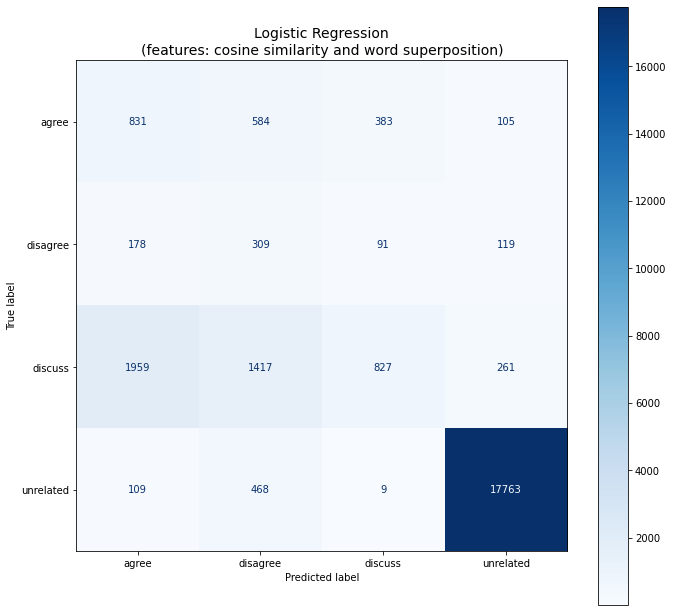

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(features: cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_logistic_regression_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

In [ ]:
cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_lr.diagonal()

array([0.43667893, 0.44332855, 0.18525986, 0.96806365])

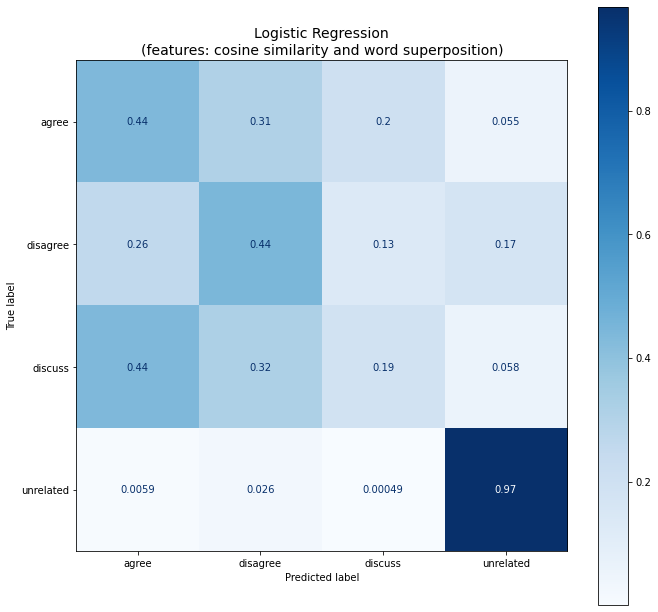

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(features: cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_logistic_regression_clf, df_X_test, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

Avaliação sobre os dados de treino

In [ ]:
y_pred_lr_train = rs_logistic_regression_clf.predict(df_X_train)
print(classification_report(y_train, y_pred_lr_train))

              precision    recall  f1-score   support

       agree       0.39      0.39      0.39     36545
    disagree       0.37      0.47      0.42     36545
     discuss       0.37      0.22      0.28     36545
   unrelated       0.85      0.97      0.91     36545

    accuracy                           0.51    146180
   macro avg       0.50      0.51      0.50    146180
weighted avg       0.50      0.51      0.50    146180



In [ ]:
lr_accuracy_train = rs_logistic_regression_clf.score(df_X_train, y_train)
round(lr_accuracy_train, 4)

0.5136

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_lr[i, y], end='\t')

## Logistic Regression (all features)

Tunning Hyperparameters

In [ ]:
logistic_regression_all = LogisticRegression(max_iter=1024)

In [ ]:
logistic_regression_all = LogisticRegression(max_iter=1024)
rs_logistic_regression_all = logistic_regression_all.fit(training_features, y_train)

In [ ]:
'''param_dist = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}'''

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
'''random_search_lr_all =\
    RandomizedSearchCV(
        estimator=logistic_regression_all,
        param_distributions=param_dist,        
        cv=5,
        scoring=scorer)'''

In [ ]:
#rs_logistic_regression_all = random_search_lr_all.fit(training_features, y_train)

In [ ]:
#dump(rs_logistic_regression_all, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_logistic_regression_all_2021_07_27.joblib')
rs_logistic_regression_all = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_logistic_regression_all_2021_07_27.joblib')

In [ ]:
#rs_logistic_regression_all.best_score_

AttributeError: ignored

In [ ]:
#rs_logistic_regression_all.best_params_

{'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
#rs_logistic_regression_clf.best_estimator_

LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1024, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Print the optimal parameters and best score
'''print("Tuned Logistic Regression Parameter: {}".format(rs_logistic_regression_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_logistic_regression_clf.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_logistic_regression_clf.best_estimator_))'''

Tuned Logistic Regression Parameter: {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}
Tuned Logistic Regression Accuracy: 0.5126898344506772
Tuned Logistic Regression Estimator:  LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1024, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
y_pred_lr_all = rs_logistic_regression_all.predict(test_features)
print(classification_report(y_test, y_pred_lr_all))

              precision    recall  f1-score   support

       agree       0.47      0.57      0.52      1903
    disagree       0.38      0.00      0.01       697
     discuss       0.74      0.70      0.72      4464
   unrelated       0.96      0.98      0.97     18349

    accuracy                           0.88     25413
   macro avg       0.63      0.56      0.55     25413
weighted avg       0.87      0.88      0.86     25413



In [ ]:
lr_accuracy_all = rs_logistic_regression_all.score(test_features, y_test)
round(lr_accuracy_all, 4)

0.8752

In [ ]:
cm_lr_all = confusion_matrix(y_test, y_pred_lr_all)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_lr_all[i, y], end='\t')


1084	3	633	183	
320	3	200	174	
853	2	3133	476	
31	0	296	18022	

In [ ]:
cm_lr_all = cm_lr_all.astype('float') / cm_lr_all.sum(axis=1)[:, np.newaxis]
cm_lr_all.diagonal()
cm_lr_all_classes_accuracy = [round(a, 4) for a in cm_lr_all.diagonal()]
for i in range(4):
  print(cm_lr_all_classes_accuracy[i])

0.5696
0.0043
0.7018
0.9822


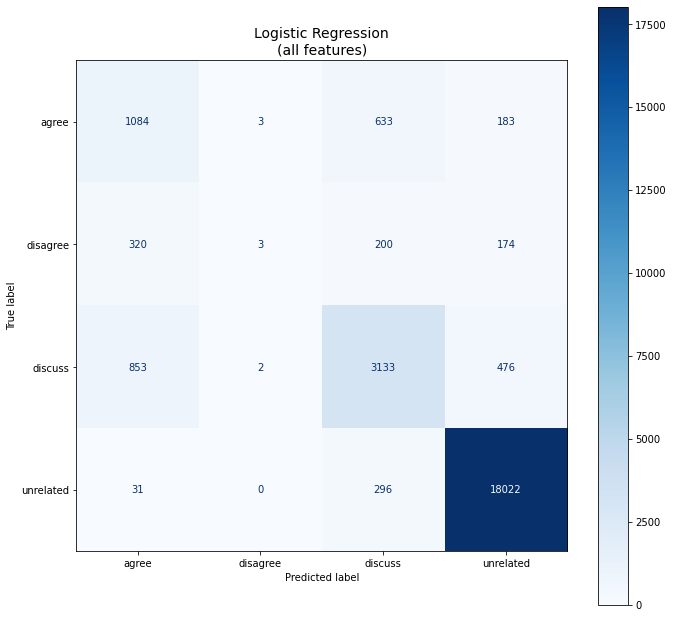

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_logistic_regression_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

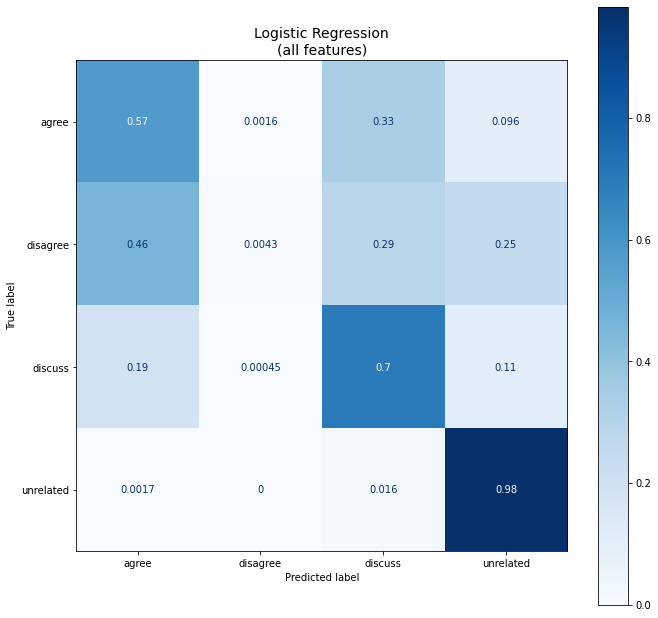

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Logistic Regression\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_logistic_regression_all, test_features, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

Avaliação sobre os dados de treino

In [ ]:
y_pred_lr_all_train = rs_logistic_regression_all.predict(training_features)
print(classification_report(y_train, y_pred_lr_all_train))

              precision    recall  f1-score   support

       agree       0.99      0.92      0.95     36545
    disagree       0.92      0.99      0.96     36545
     discuss       0.99      0.99      0.99     36545
   unrelated       0.99      0.99      0.99     36545

    accuracy                           0.97    146180
   macro avg       0.97      0.97      0.97    146180
weighted avg       0.97      0.97      0.97    146180



In [ ]:
lr_accuracy_all_train = rs_logistic_regression_all.score(training_features, y_train)
round(lr_accuracy_all_train, 4)

0.9735

### Naive Bayes (cosine similarity and word superposition)

Tunning Hyperparameters

In [ ]:
naive_bayes_clf = MultinomialNB(fit_prior=False)

In [ ]:
param_dist_nb = {
    'alpha': np.logspace(-4, 4, 20)
}     

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
random_search_nb =\
    RandomizedSearchCV(
        estimator=naive_bayes_clf,
        param_distributions=param_dist_nb,        
        cv=5,
        scoring=scorer)

In [ ]:
#rs_naive_bayes_clf = random_search_nb.fit(df_X_train, y_train)

In [ ]:
#dump(rs_naive_bayes_clf, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_naive_bayes_clf_2021_07_27.joblib')
rs_naive_bayes_clf = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_naive_bayes_clf_2021_07_27.joblib')

In [ ]:
rs_naive_bayes_clf.best_score_

0.29488302093309615

In [ ]:
rs_naive_bayes_clf.best_params_

{'alpha': 1438.44988828766}

In [ ]:
rs_naive_bayes_clf.best_estimator_

MultinomialNB(alpha=1438.44988828766, class_prior=None, fit_prior=False)

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_naive_bayes_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_naive_bayes_clf.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_naive_bayes_clf.best_estimator_))

Tuned Logistic Regression Parameter: {'alpha': 1438.44988828766}
Tuned Logistic Regression Accuracy: 0.29488302093309615
Tuned Logistic Regression Estimator:  MultinomialNB(alpha=1438.44988828766, class_prior=None, fit_prior=False)


In [ ]:
y_pred_nb = rs_naive_bayes_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_nb, zero_division=0))

              precision    recall  f1-score   support

       agree       0.02      0.12      0.03      1903
    disagree       0.07      0.65      0.13       697
     discuss       0.33      0.02      0.03      4464
   unrelated       0.78      0.26      0.39     18349

    accuracy                           0.22     25413
   macro avg       0.30      0.26      0.15     25413
weighted avg       0.62      0.22      0.29     25413



In [ ]:
nb_accuracy = rs_naive_bayes_clf.score(df_X_test, y_test)
round(nb_accuracy, 4)

0.2178

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_nb[i, y], end='\t')


220	1340	47	296	
70	455	11	161	
576	2940	67	881	
12013	1462	81	4793	

In [ ]:
cm_nb = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]
cm_nb.diagonal()
cm_nb_classes_accuracy = [round(a, 4) for a in cm_nb.diagonal()]
for i in range(4):
  print(cm_nb_classes_accuracy[i])

0.1156
0.6528
0.015
0.2612


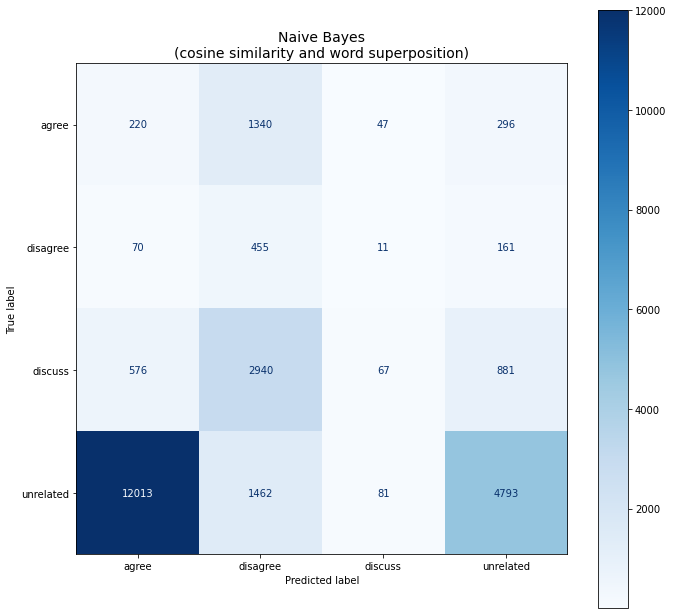

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_naive_bayes_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

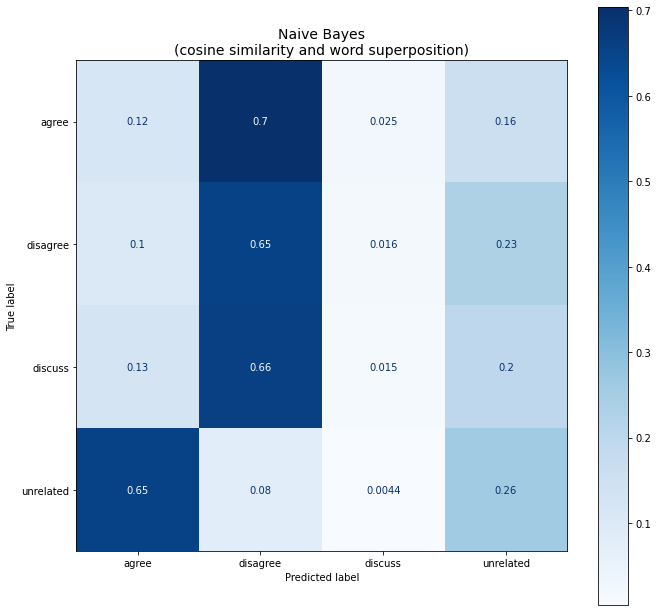

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_naive_bayes_clf, df_X_test, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

### Naive Bayes (all features)

Tunning Hyperparameters

In [ ]:
naive_bayes_all = MultinomialNB()

In [ ]:
param_dist_nb = {
    'alpha': np.logspace(-4, 4, 20)
}     

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
random_search_nb_all =\
    RandomizedSearchCV(
        estimator=naive_bayes_all,
        param_distributions=param_dist_nb,        
        cv=5,
        scoring=scorer)

In [ ]:
#rs_naive_bayes_all = random_search_nb_all.fit(training_features, y_train)

In [ ]:
#dump(rs_naive_bayes_all, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_naive_bayes_all_2021_07_27.joblib')
rs_naive_bayes_all = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_naive_bayes_all_2021_07_27.joblib')

In [ ]:
rs_naive_bayes_all.best_score_

0.6300451498152961

In [ ]:
rs_naive_bayes_all.best_params_

{'alpha': 1.623776739188721}

In [ ]:
rs_naive_bayes_all.best_estimator_

MultinomialNB(alpha=1.623776739188721, class_prior=None, fit_prior=True)

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_naive_bayes_all.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_naive_bayes_all.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_naive_bayes_all.best_estimator_))

Tuned Logistic Regression Parameter: {'alpha': 1.623776739188721}
Tuned Logistic Regression Accuracy: 0.6300451498152961
Tuned Logistic Regression Estimator:  MultinomialNB(alpha=1.623776739188721, class_prior=None, fit_prior=True)


In [ ]:
y_pred_nb_all = rs_naive_bayes_all.predict(test_features)
print(classification_report(y_test, y_pred_nb_all))

              precision    recall  f1-score   support

       agree       0.16      0.53      0.25      1903
    disagree       0.13      0.09      0.11       697
     discuss       0.28      0.43      0.34      4464
   unrelated       0.82      0.53      0.65     18349

    accuracy                           0.50     25413
   macro avg       0.35      0.40      0.34     25413
weighted avg       0.66      0.50      0.55     25413



In [ ]:
nb_accuracy_all = rs_naive_bayes_all.score(test_features, y_test)
round(nb_accuracy_all, 4)

0.5012

In [ ]:
cm_nb_all = confusion_matrix(y_test, y_pred_nb_all)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_nb_all[i, y], end='\t')


1003	83	313	504	
327	66	67	237	
1116	87	1920	1341	
3756	280	4565	9748	

In [ ]:
cm_nb_all = cm_nb_all.astype('float') / cm_nb_all.sum(axis=1)[:, np.newaxis]
cm_nb_all.diagonal()
cm_nb_all_classes_accuracy = [round(a, 4) for a in cm_nb_all.diagonal()]
for i in range(4):
  print(cm_nb_all_classes_accuracy[i])

0.5271
0.0947
0.4301
0.5313


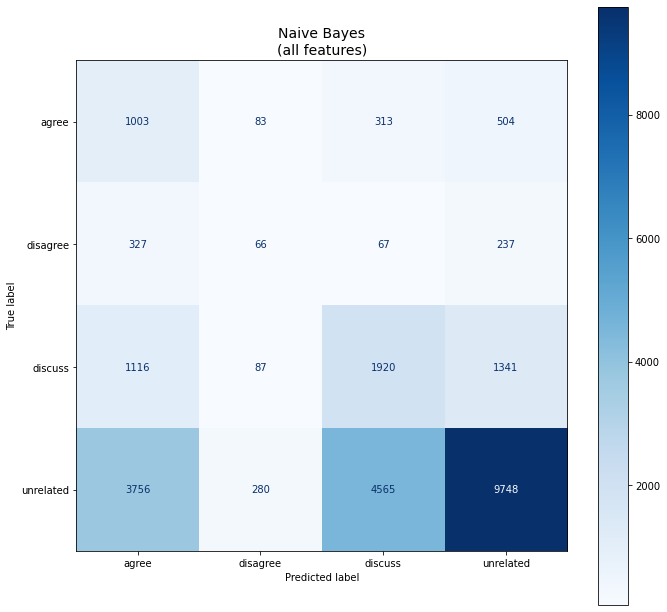

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_naive_bayes_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

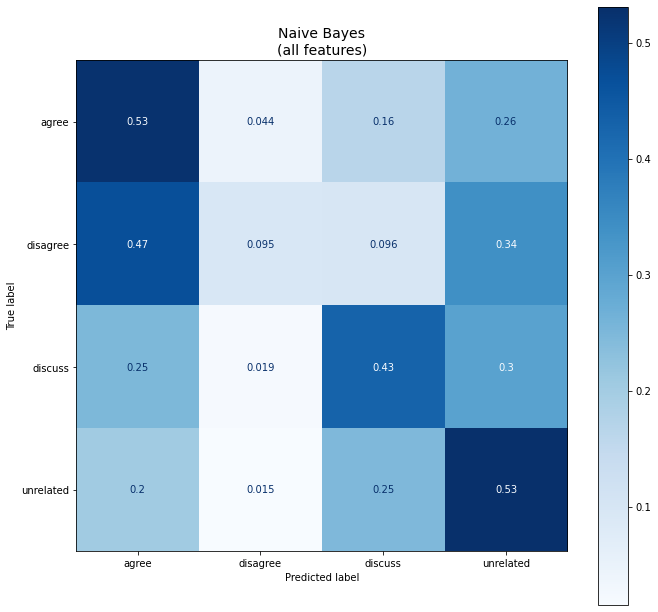

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Naive Bayes\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_naive_bayes_all, test_features, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

### Random Forest (cosine similarity and word superposition)

Tunning Hyperparameters

In [ ]:
#random_forest_clf = RandomForestClassifier()

In [ ]:
#param_dist_rf = {'n_estimators' : list(range(10,101,10))}

In [ ]:
#scorer = make_scorer(accuracy_score)

In [ ]:
'''random_search_rf =\
    RandomizedSearchCV(
        estimator=random_forest_clf,
        param_distributions=param_dist_rf,        
        cv=5,
        scoring=scorer)'''

In [ ]:
#rs_random_forest_clf = random_search_rf.fit(df_X_train, y_train)

In [ ]:
#dump(rs_random_forest_clf, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_random_forest_clf_2021_07_27.joblib')
rs_random_forest_clf = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_random_forest_clf_2021_07_27.joblib')

In [ ]:
cross_val_score(estimator=rs_random_forest_clf, X=df_X_test, y=y_test, cv=5)

array([0.85362975, 0.8510722 , 0.84812119, 0.8364817 , 0.83963007])

In [ ]:
rs_random_forest_clf.best_score_

0.9773087973731016

In [ ]:
rs_random_forest_clf.best_params_

{'n_estimators': 80}

In [ ]:
rs_random_forest_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_random_forest_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_random_forest_clf.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_random_forest_clf.best_estimator_))

Tuned Logistic Regression Parameter: {'n_estimators': 80}
Tuned Logistic Regression Accuracy: 0.9773087973731016
Tuned Logistic Regression Estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
y_pred_rf = rs_random_forest_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       agree       0.26      0.24      0.25      1903
    disagree       0.10      0.05      0.06       697
     discuss       0.58      0.66      0.62      4464
   unrelated       0.97      0.97      0.97     18349

    accuracy                           0.83     25413
   macro avg       0.48      0.48      0.47     25413
weighted avg       0.82      0.83      0.83     25413



In [ ]:
rf_accuracy = rs_random_forest_clf.score(df_X_test, y_test)
round(rf_accuracy, 4)

0.8313

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_rf[i, y], end='\t')


449	63	1246	145	
132	32	396	137	
1035	172	2931	326	
140	51	445	17713	

In [ ]:
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
cm_rf.diagonal()
cm_rf_classes_accuracy = [round(a, 4) for a in cm_rf.diagonal()]
for i in range(4):
  print(cm_rf_classes_accuracy[i])

0.2359
0.0459
0.6566
0.9653


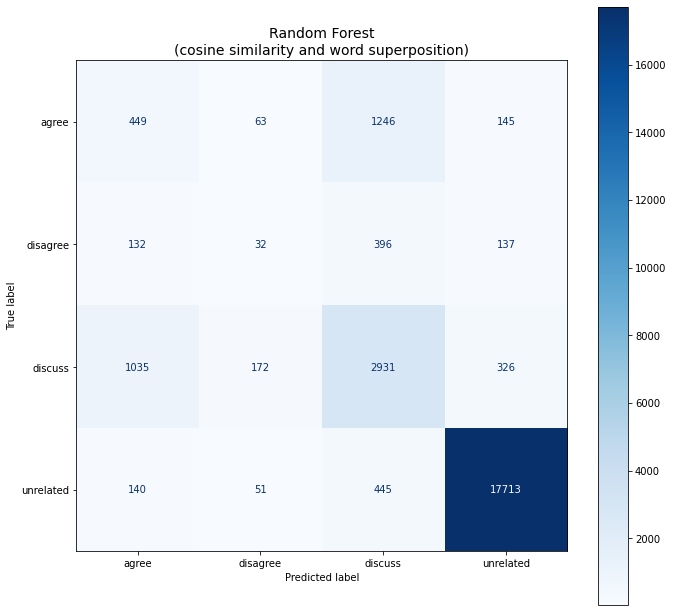

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_random_forest_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

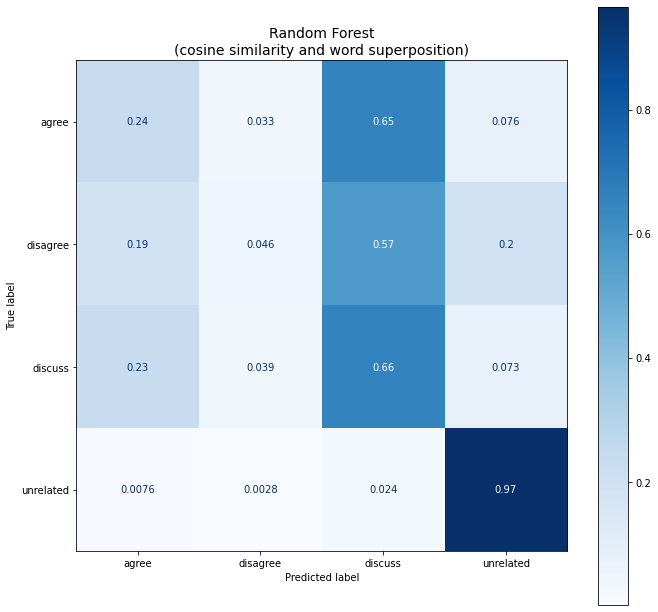

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_random_forest_clf, df_X_test, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

Avaliação sobre os dados de treino

In [ ]:
y_pred_rf_train = rs_random_forest_clf.predict(df_X_train)
print(classification_report(y_train, y_pred_rf_train))

              precision    recall  f1-score   support

       agree       0.99      0.98      0.98     36545
    disagree       0.99      0.99      0.99     36545
     discuss       1.00      0.98      0.99     36545
   unrelated       0.98      1.00      0.99     36545

    accuracy                           0.99    146180
   macro avg       0.99      0.99      0.99    146180
weighted avg       0.99      0.99      0.99    146180



In [ ]:
rf_accuracy_train = rs_random_forest_clf.score(df_X_train, y_train)
round(rf_accuracy_train, 4)

0.987

### Random Forest (all features)

Tunning Hyperparameters

In [ ]:
random_forest_all = RandomForestClassifier()

In [ ]:
random_forest_all = RandomForestClassifier()
rs_random_forest_all = random_forest_all.fit(training_features, y_train)

In [ ]:
param_dist_rf = {'n_estimators': 80}

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
random_search_rf_all =\
    RandomizedSearchCV(
        estimator=random_forest_clf,
        param_distributions=param_dist_rf,        
        cv=5,
        scoring=scorer)

In [ ]:
rs_random_forest_all = random_search_rf.fit(training_features, y_train)

In [ ]:
 dump(rs_random_forest_all, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_random_forest_all_2021_07_27.joblib')
#rs_random_forest_all = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_random_forest_all_2021_07_27.joblib')

In [ ]:
rs_random_forest_all.best_score_

AttributeError: ignored

In [ ]:
rs_random_forest_all.best_params_

In [ ]:
rs_random_forest_all.best_estimator_

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_random_forest_all.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_random_forest_all.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_random_forest_all.best_estimator_))

In [ ]:
y_pred_rf_all = rs_random_forest_all.predict(test_features)
print(classification_report(y_test, y_pred_rf_all))

ValueError: ignored

In [ ]:
rf_accuracy_all = rs_random_forest_all.score(test_features, y_test)
round(rf_accuracy_all, 4)

In [ ]:
cm_rf_all = confusion_matrix(y_test, y_pred_rf_all)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_rf_all[i, y], end='\t')

In [ ]:
cm_rf_all = cm_rf_all.astype('float') / cm_rf_all.sum(axis=1)[:, np.newaxis]
cm_rf_all.diagonal()
cm_rf_all_classes_accuracy = [round(a, 4) for a in cm_rf_all.diagonal()]
for i in range(4):
  print(cm_rf_all_classes_accuracy[i])

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_random_forest_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Random Forest\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_random_forest_all, test_features, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

Avaliação sobre os dados de treino

In [ ]:
y_pred_rf_all_train = rs_random_forest_all.predict(training_features)
print(classification_report(y_train, y_pred_rf_all_train))

In [ ]:
rf_accuracy_all = rs_random_forest_all.score(test_features, y_test)
round(rf_accuracy_all, 4)

### Multi-layer Perceptron Classifier (cosine similarity and word superposition)

Tunning Hyperparameters

In [ ]:
neural_network_clf = MLPClassifier()

In [ ]:
param_dist_nn = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
random_search_nn =\
    RandomizedSearchCV(
        estimator=neural_network_clf,
        param_distributions=param_dist_nn,        
        cv=5,
        scoring=scorer)

In [ ]:
rs_neural_network_clf = random_search_nn.fit(df_X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
dump(rs_neural_network_clf, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_neural_network_clf_2021_07_27.joblib')
#rs_neural_network_clf = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_neural_network_clf_2021_07_27.joblib')

['/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_neural_network_clf_2021_07_27.joblib']

In [ ]:
rs_neural_network_clf.best_score_

0.5720550006840881

In [ ]:
rs_neural_network_clf.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [ ]:
rs_neural_network_clf.best_estimator_

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(rs_neural_network_clf.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_neural_network_clf.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_neural_network_clf.best_estimator_))

Tuned Logistic Regression Parameter: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Tuned Logistic Regression Accuracy: 0.5720550006840881
Tuned Logistic Regression Estimator:  MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [ ]:
nn_accuracy = rs_neural_network_clf.score(df_X_test, y_test)
round(nn_accuracy, 4)

0.7702

In [ ]:
y_pred_nn = rs_neural_network_clf.predict(df_X_test)
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

       agree       0.26      0.40      0.32      1903
    disagree       0.09      0.35      0.14       697
     discuss       0.55      0.25      0.34      4464
   unrelated       0.98      0.95      0.97     18349

    accuracy                           0.77     25413
   macro avg       0.47      0.49      0.44     25413
weighted avg       0.83      0.77      0.79     25413



In [ ]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_nn[i, y], end='\t')


768	587	474	74	
174	243	199	81	
1738	1443	1118	165	
230	430	244	17445	

In [ ]:
cm_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
cm_nn.diagonal()
cm_nn_classes_accuracy = [round(a, 4) for a in cm_nn.diagonal()]
for i in range(4):
  print(cm_nn_classes_accuracy[i])

0.4036
0.3486
0.2504
0.9507


In [ ]:
#tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlpc).ravel()
#(tn, fp, fn, tp)

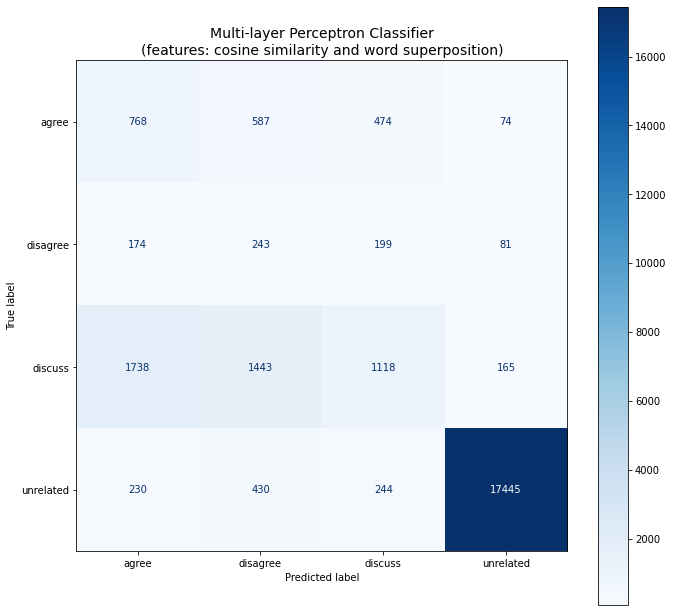

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(features: cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_neural_network_clf, df_X_test, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

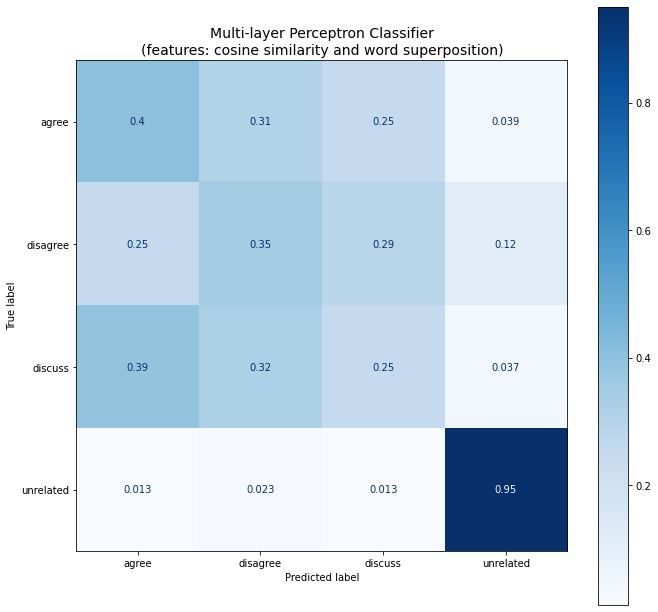

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(features: cosine similarity and word superposition)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_neural_network_clf, df_X_test, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

### Multi-layer Perceptron Classifier (all features)

Tunning Hyperparameters

In [ ]:
#neural_network_all = MLPClassifier()

In [ ]:
neural_network_all = MLPClassifier()
rs_neural_network_all = neural_network_all.fit(training_features, y_train)

In [ ]:
param_dist_nn = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
scorer = make_scorer(accuracy_score)

In [ ]:
'''random_search_nn_all =\
    RandomizedSearchCV(
        estimator=neural_network_all,
        param_distributions=param_dist_nn,        
        cv=5,
        scoring=scorer)'''

In [ ]:
#rs_neural_network_all = random_search_nn.fit(training_features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
dump(rs_neural_network_all, '/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_neural_network_all_2021_07_27.joblib')
#rs_neural_network_all = load('/content/drive/MyDrive/Colab Notebooks/Stance Detection definitive edition FNC dataset v3 (random oversample)/rs_neural_network_all_2021_07_27.joblib')

In [ ]:
#rs_neural_network_all.best_score_

In [ ]:
#rs_neural_network_all.best_params_

In [ ]:
#rs_neural_network_all.best_estimator_

In [ ]:
# Print the optimal parameters and best score
'''print("Tuned Logistic Regression Parameter: {}".format(rs_neural_network_all.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(rs_neural_network_all.best_score_))
print("Tuned Logistic Regression Estimator:  {}".format(rs_neural_network_all.best_estimator_))'''

In [ ]:
y_pred_nn_all = rs_neural_network_all.predict(test_features)
print(classification_report(y_test, y_pred_nn_all))

In [ ]:
nn_accuracy_all = rs_neural_network_all.score(test_features, y_test)
round(nn_accuracy_all, 4)

In [ ]:
cm_nn_all = confusion_matrix(y_test, y_pred_nn_all)
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_nn_all[i, y], end='\t')

In [ ]:
cm_nn_all = cm_nn_all.astype('float') / cm_nn_all.sum(axis=1)[:, np.newaxis]
cm_nn_all.diagonal()
cm_nn_all_classes_accuracy = [round(a, 4) for a in cm_nn_all.diagonal()]
for i in range(4):
  print(cm_nn_all_classes_accuracy[i])

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_neural_network_all, test_features, y_test, values_format='d', cmap='Blues', ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
ax.set_title('Multi-layer Perceptron Classifier\n(all features)', fontdict = {'family':'sans-serif', 'weight':'normal', 'size': 14})
plot_confusion_matrix(rs_neural_network_all, test_features, y_test, cmap='Blues', ax=ax, normalize='true')
plt.show()

## ROC curves

### ROC curves (consine similarity and word superposition)

In [ ]:
labels = ['Logistic regression', 'Multinomial Naive Bayes', 'Random Forest', 'Multi-layer Perceptron Classifier']
scores = [lr_accuracy, nb_accuracy, rf_accuracy, nn_accuracy]
scores = [round(i * 100, 2) for i in scores]

scores_all = [lr_accuracy_all, nb_accuracy_all, rf_accuracy_all, nn_accuracy_all]
scores_all = [round(i * 100, 2) for i in scores_all]

w = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(w - width/2, scores, width, label='Features: cosine similarity and word superposition')
rects2 = ax.bar(w + width/2, scores_all, width, label='Features: TF-IDF, cosine similarity and word superposition')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores', fontsize='18')
ax.set_title('Accuracy by algorithms trainned with or without TF-IDF features', fontsize='24')
ax.set_xticks(w)

ax.set_xticklabels(labels, fontsize='12')
ax.legend(fontsize='12')
#ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()

for i in range(len(scores)):
    ax.annotate(str(scores[i])+'       ', xy=(w[i],scores[i]), ha='right', va='bottom', fontsize='14')

for i in range(len(scores_all)):
    ax.annotate(str(scores_all[i]), xy=(w[i],scores_all[i]), ha='left', va='bottom', fontsize='14')    


plt.ylim([0, 119])
#fig.tight_layout()

plt.show()
print(scores)

In [ ]:
def change(f):
    if f == 'disagree':
        return 1    
    else:
        return 0

y_train_number = [change(x) for x in y_train]
y_test_number = [change(x) for x in y_test]

In [ ]:
r_probs = [0 for _ in range(len(y_test))]
lr_probs = rs_logistic_regression_clf.predict_proba(df_X_test)#[:, 1]
nb_probs = rs_naive_bayes_clf.predict_proba(df_X_test)#[:, 1]
rf_probs = rs_random_forest_clf.predict_proba(df_X_test)#[:, 1]
nn_probs = rs_neural_network_clf.predict_proba(df_X_test)#[:, 1]

In [ ]:
#r_auc = roc_auc_score(y_test, r_probs, labels=['agree', 'disagree', 'discuss', 'unrelated'], multi_class='ovr')
lr_auc = roc_auc_score(y_test, lr_probs, labels=['agree', 'disagree', 'discuss', 'unrelated'], multi_class='ovr')
nb_auc = roc_auc_score(y_test, nb_probs, labels=['agree', 'disagree', 'discuss', 'unrelated'], multi_class='ovr')
rf_auc = roc_auc_score(y_test, rf_probs, labels=['agree', 'disagree', 'discuss', 'unrelated'], multi_class='ovr')
nn_auc = roc_auc_score(y_test, nn_probs, labels=['agree', 'disagree', 'discuss', 'unrelated'], multi_class='ovr')

In [ ]:
#print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Neural Network: AUROC = %.3f' % (nn_auc))

In [ ]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)#, pos_label='disagree')
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)#, pos_label='disagree')
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)#, pos_label='disagree')
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)#, pos_label='disagree')
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)#, pos_label='disagree')

In [ ]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc)
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc)

# Title
plt.title('ROC curves\n(features: consine similarity and word superposition)', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
plt.legend(fontsize='12') # 
# Show plot
plt.show()

### ROC curves (all features)

In [ ]:
r_probs_all = [0 for _ in range(len(y_test_number))]
lr_probs_all = logistic_regression_all.predict_proba(test_features)[:, 1]
nb_probs_all = naive_bayes_all.predict_proba(test_features)[:, 1]
rf_probs_all = random_forest_all.predict_proba(test_features)[:, 1]
nn_probs_all = neural_network_all.predict_proba(test_features)[:, 1]

In [ ]:
r_auc_all = roc_auc_score(y_test_number, r_probs_all)
lr_auc_all = roc_auc_score(y_test_number, lr_probs_all)
nb_auc_all = roc_auc_score(y_test_number, nb_probs_all)
rf_auc_all = roc_auc_score(y_test_number, rf_probs_all)
nn_auc_all = roc_auc_score(y_test_number, nn_probs_all)

In [ ]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc_all))
print('Linear Regression: AUROC = %.3f' % (lr_auc_all))
print('Naive Bayes: AUROC = %.3f' % (nb_auc_all))
print('Random Forest: AUROC = %.3f' % (rf_auc_all))
print('Neural Network: AUROC = %.3f' % (nn_auc_all))

In [ ]:
r_fpr_all, r_tpr_all, _ = roc_curve(y_test_number, r_probs_all)#, pos_label='disagree')
lr_fpr_all, lr_tpr_all, _ = roc_curve(y_test_number, lr_probs_all)#, pos_label='disagree')
nb_fpr_all, nb_tpr_all, _ = roc_curve(y_test_number, nb_probs_all)#, pos_label='disagree')
rf_fpr_all, rf_tpr_all, _ = roc_curve(y_test_number, rf_probs_all)#, pos_label='disagree')
nn_fpr_all, nn_tpr_all, _ = roc_curve(y_test_number, nn_probs_all)#, pos_label='disagree')

In [ ]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr_all, r_tpr_all, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc_all)
plt.plot(lr_fpr_all, lr_tpr_all, marker='.', label='Logistic Regression (AUC = %0.3f)' % lr_auc_all)
plt.plot(nb_fpr_all, nb_tpr_all, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc_all)
plt.plot(rf_fpr_all, rf_tpr_all, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc_all)
plt.plot(nn_fpr_all, nn_tpr_all, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc_all)

# Title
plt.title('ROC curves\n(features: TF-IDF, consine similarity and word superposition)', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
plt.legend(fontsize='12') # 
# Show plot
plt.show()

## Confusion matrices comparative

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers = [logistic_regression_clf, naive_bayes_clf, random_forest_clf, neural_network_clf]

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          df_X_test, 
                          y_test, 
                          ax=ax,
                          values_format='d', 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers_all = [logistic_regression_all, naive_bayes_all, random_forest_all, neural_network_all]

for cls, ax in zip(classifiers_all, axes.flatten()):
    plot_confusion_matrix(cls, 
                          test_features, 
                          y_test, 
                          ax=ax,
                          values_format='d', 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

To be continued...

In [ ]:
fig, ax = plt.subplots(figsize=(11,11), )
plt.plot(r_fpr_all, r_tpr_all, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc_all)
plt.plot(lr_fpr_all, lr_tpr_all, marker='.', label='Logistic Regression (AUC = %0.3f)' % lr_auc_all)
#plt.plot(nb_fpr_all, nb_tpr_all, marker='.', label='Naive Bayes (AUC = %0.3f)' % nb_auc_all)
#plt.plot(rf_fpr_all, rf_tpr_all, marker='.', label='Random Forest (AUC = %0.3f)' % rf_auc_all)
#plt.plot(nn_fpr_all, nn_tpr_all, marker='.', label='Neural Network (AUC = %0.3f)' % nn_auc_all)

# Title
plt.title('Receiver Operator Characteristic - ROC', fontsize='20')
# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize='18')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize='18')
# Show legend
#plt.legend(fontsize='12') # 
# Show plot
plt.show()

In [ ]:
for i in range(4):
  print('')      
  for y in range(4):
    print(cm_lr[i, y], end='\t')

In [ ]:
cm_lr = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_lr.diagonal()
cm_lr_classes_accuracy = [round(a, 4) for a in cm_lr.diagonal()]
for i in range(4):
  print(cm_lr_classes_accuracy[i])